In [1]:
#FIRST TASK
#Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
#Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

In [79]:
import tensorflow as tf
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os, random
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
import warnings
warnings.filterwarnings('ignore')

In [82]:
path = "./text.txt"
with open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
text = text[:10000]
print("Text length:", len(text))

Text length: 8025


In [83]:
ch_s = sorted(list(set(text)))
print("Total chars:", len(ch_s))
ch_i = dict((c, i) for i, c in enumerate(ch_s))
ind_ch = dict((i, c) for i, c in enumerate(ch_s))

Total chars: 45


In [84]:
maxlen = 40
step = 1
sentences = []
next_ch_s = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_ch_s.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(ch_s)), dtype="bool")
y = np.zeros((len(sentences), len(ch_s)), dtype="bool")

for i, sentence in enumerate(sentences):
    for t, ch in enumerate(sentence):
        x[i, t, ch_i[ch]] = 1
    y[i, ch_i[next_ch_s[i]]] = 1

Number of sequences: 7985


In [86]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)
model = tf.keras.Sequential([tf.keras.Input(shape=(maxlen, len(ch_s))), layers.LSTM(128), layers.Dense(len(ch_s), activation="softmax"),])
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01)

model.compile(loss="categorical_crossentropy", optimizer = optimizer)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               89088     
                                                                 
 dense_28 (Dense)            (None, 45)                5805      
                                                                 
Total params: 94893 (370.68 KB)
Trainable params: 94893 (370.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
def smpl(pred_s, temp = 1.0):
    pred_s = np.asarray(pred_s).astype("float64")
    pred_s = np.log(pred_s) / temp
    
    exp_pred_s = np.exp(pred_s)
    pred_s = exp_pred_s / np.sum(exp_pred_s)
    
    probas = np.random.multinomial(1, pred_s, 1)
    return np.argmax(probas)

In [89]:
model.fit(x, y, batch_size = 128, epochs = 100, callbacks = [callback])

Epoch 1/100
63/63 [==============================] - 2s 30ms/step - loss: 2.3777
Epoch 2/100
63/63 [==============================] - 2s 31ms/step - loss: 2.2564
Epoch 3/100
63/63 [==============================] - 2s 32ms/step - loss: 2.1321
Epoch 4/100
63/63 [==============================] - 2s 32ms/step - loss: 2.0036
Epoch 5/100
63/63 [==============================] - 2s 32ms/step - loss: 1.8651
Epoch 6/100
63/63 [==============================] - 2s 31ms/step - loss: 1.7209
Epoch 7/100
63/63 [==============================] - 2s 29ms/step - loss: 1.5766
Epoch 8/100
63/63 [==============================] - 2s 28ms/step - loss: 1.4280
Epoch 9/100
63/63 [==============================] - 2s 29ms/step - loss: 1.2824
Epoch 10/100
63/63 [==============================] - 2s 33ms/step - loss: 1.1553
Epoch 11/100
63/63 [==============================] - 2s 34ms/step - loss: 1.0341
Epoch 12/100
63/63 [==============================] - 2s 33ms/step - loss: 0.9210
Epoch 13/100
63/63 [=====

In [91]:
start_i = random.randint(0, len(text) - maxlen - 1)
gen = ""

sentence = text[start_i : start_i + maxlen]
print('In process with: "' + sentence + '"')

for i in range(300):
    x_pred = np.zeros((1, maxlen, len(ch_s)))
    
    for t, ch in enumerate(sentence):
        x_pred[0, t, ch_i[ch]] = 1.0
    
    pred_s = model.predict(x_pred)[0]
    next_i = np.argmax(pred_s)
    next_ch = ind_ch[next_i]
    
    sentence = sentence[1:] + next_ch
    gen += next_ch

print("Final result: ", gen)
print("^^^^^^^^^^^^^^^^^^")

In process with: " він одружується. за описом майбутньої д"
1/1 [==============================] - 0s 30ms/step
Generated:  ружини товариша, степан впізнає надійку. від теж «прикро, певно, погондентя й подомувала степан вирішив показати оповідання віданкою. слій з неваровути всі зв'язки з дівчиною. спочатку він жив у столярній майшов степан купує степан впав у розпач, були моменти, коли плив з нею і левком на пароплавію 
^^^^^^^^^^^^^^^^^^


In [93]:
start_i = random.randint(0, len(text) - maxlen - 1)

for div in [0.2, 0.5, 1.0, 1.2]:
    print("For diversity =", div)

    gen = ""
    sentence = text[start_i : start_i + maxlen]
    print('In process with: "' + sentence + '"')
        
    for i in range(300):
        x_pred = np.zeros((1, maxlen, len(ch_s)))
        
        for t, ch in enumerate(sentence):
            x_pred[0, t, ch_i[ch]] = 1.0
            
        pred_s = model.predict(x_pred, verbose = 0)[0]
        next_i = smpl(pred_s, div)
        next_ch = ind_ch[next_i]
        
        sentence = sentence[1:] + next_ch
        gen += next_ch
    
    print("Final result: ", gen)
    print("^^^^^^^^^^^^^^^^^^")

For diversity = 0.2
In process with: "на велике враження. він із заздрістю слу"
Final result:  хав майстер й розоз завдяння ті вістає степан впізнає надійку. від теж «прикро, певно, погондентя й подомувала степан вирішив показати оповідання віданий полів». з важким серцем вийшов від неї на вулицю – непоказний спокій надійки обурив його. раптом зусявати у невдовзі він зустрічає свого з мусу ст
^^^^^^^^^^^^^^^^^^
For diversity = 0.5
In process with: "на велике враження. він із заздрістю слу"
Final result:  хав майстер й розполаю і став студентом. мав тим спровою стає справ навіть розмовляти з ним. відчуваючи себе приниженим, х покірня тволодо місту свого інституті, коли піи в тикурних дістається персонажів… перельку, посбіл на непокізний спокій надійки обурив його. рапомів на його не утримувала, знала
^^^^^^^^^^^^^^^^^^
For diversity = 1.0
In process with: "на велике враження. він із заздрістю слу"
Final result:  хав майстерне читання цієї зміни, якого його ще обдружбє більш «плагородним

In [2]:
#SECOND TASK
#Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

In [75]:
from transformers import TokenClassificationPipeline, AutoTokenizer, AutoModelForTokenClassification
tokenizer = AutoTokenizer.from_pretrained('ukr-models/uk-morph')
model = AutoModelForTokenClassification.from_pretrained('ukr-models/uk-morph')

In [76]:
pipeline = TokenClassificationPipeline(model = model, tokenizer = tokenizer)

In [78]:
pipeline("Здавалось, далі пливти нема куди. Спереду Дніпро мов спинився в несподіваній затоці, оточений праворуч, ліворуч і просто зелено-жовтими передосінніми берегами. Але пароплав раптом звернув, і довга, спокійна смуга річки протяглася далі до ледве помітних пагорків на обрії.")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'VERB__Aspect=Imp|Gender=Neut|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin',
  'score': 0.99999607,
  'index': 1,
  'word': '▁З',
  'start': 0,
  'end': 1},
 {'entity': 'VERB__Aspect=Imp|Gender=Neut|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin',
  'score': 0.99999535,
  'index': 2,
  'word': 'да',
  'start': 1,
  'end': 3},
 {'entity': 'VERB__Aspect=Imp|Gender=Neut|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin',
  'score': 0.9999957,
  'index': 3,
  'word': 'валось',
  'start': 3,
  'end': 9},
 {'entity': 'PUNCT',
  'score': 0.9999988,
  'index': 4,
  'word': ',',
  'start': 9,
  'end': 10},
 {'entity': 'ADV',
  'score': 0.99999905,
  'index': 5,
  'word': '▁далі',
  'start': 10,
  'end': 15},
 {'entity': 'VERB__Aspect=Imp|VerbForm=Inf',
  'score': 0.99978095,
  'index': 6,
  'word': '▁',
  'start': 15,
  'end': 16},
 {'entity': 'VERB__Aspect=Imp|VerbForm=Inf',
  'score': 0.9998336,
  'index': 7,
  'word': 'плив',
  'start': 16,
  'end': 20},
 {'entity': 'VERB__Aspect=Imp|Ve

In [3]:
#THIRD TASK
#Завдання щодо генерації або стилізації зображень (на вибір)
#Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [94]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5

train_set = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(256)

cross_entr = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [95]:
def models_generator():
    mod = Sequential()
    mod.add(Dense(7 * 7 * 256, input_shape = (100,)))
    mod.add(BatchNormalization())
    mod.add(LeakyReLU())

    mod.add(Reshape((7, 7, 256)))
    assert mod.output_shape == (None, 7, 7, 256)

    mod.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same'))
    assert mod.output_shape == (None, 7, 7, 128)
    
    mod.add(BatchNormalization())
    mod.add(LeakyReLU())

    mod.add(Conv2DTranspose(64, (5, 5), strides = (2,2 ), padding = 'same'))
    assert mod.output_shape == (None, 14, 14, 64)
    
    mod.add(BatchNormalization())
    mod.add(LeakyReLU())

    mod.add(Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))
    assert mod.output_shape == (None, 28, 28, 1)

    return mod

def gen_loss(f_out):
    return cross_entr(tf.ones_like(f_out), f_out)

In [96]:
def models_discriminator():
    mod = Sequential()
    mod.add(Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape=[28, 28, 1]))
    mod.add(LeakyReLU())
    mod.add(Dropout(0.3))

    mod.add(Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    mod.add(LeakyReLU())
    mod.add(Dropout(0.3))

    mod.add(Flatten())
    mod.add(Dense(1))

    return mod

def discr_loss(t_out, f_out):
    single_loss = cross_entr(tf.ones_like(t_out), t_out)
    snot_loss = cross_entr(tf.zeros_like(f_out), f_out)
    sum_loss = single_loss + snot_loss
    
    return sum_loss

In [97]:
seed = tf.random.normal([16, 100])

def train_single_s(images):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as generator_t, tf.GradientTape() as discriminator_t:
        gen_img = mod_generator(noise, training = True)

        t_out = mod_discriminator(images, training = True)
        f_out = mod_discriminator(gen_img, training = True)

        gener_loss = gen_loss(f_out)
        discrim_loss = discr_loss(t_out, f_out)

    g_generator = generator_t.gradient(gener_loss, mod_generator.trainable_variables)
    g_discriminator = discriminator_t.gradient(discrim_loss, mod_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(g_generator, mod_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(g_discriminator, mod_discriminator.trainable_variables))

In [98]:
def generate_plot_from_imgs(model, epoch, test_input):
    pred = model(test_input, training = False)

    fig = plt.figure(figsize=(4,4))

    for i in range(pred.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap = 'grey')
        
    plt.show()

In [99]:
def training_m(d_s, epoches):
    for epoch in range(epoches):

        for image_batch in d_s:
            train_single_s(image_batch)

        if epoch % 5 == 0:
            print(f"On epoch {epoch} result is:")
            generate_plot_from_imgs(mod_generator, epoch, seed)

On epoch 0 result is:


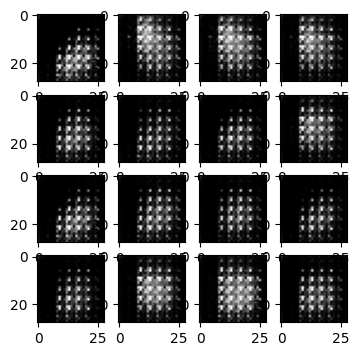

On epoch 5 result is:


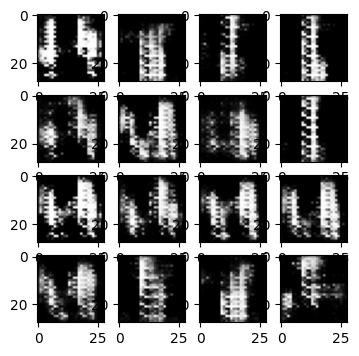

On epoch 10 result is:


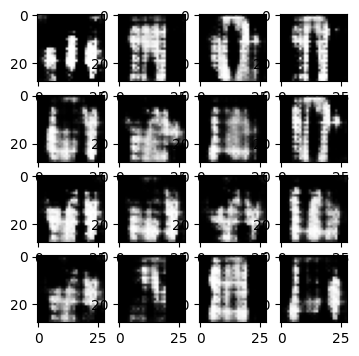

On epoch 15 result is:


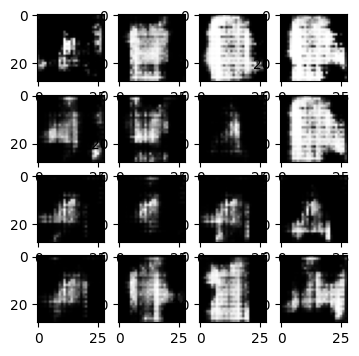

On epoch 20 result is:


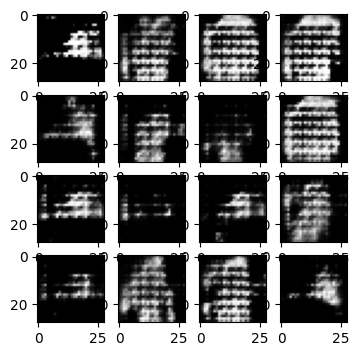

On epoch 25 result is:


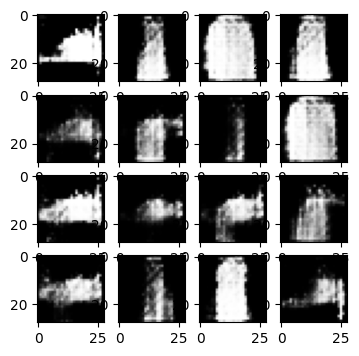

On epoch 30 result is:


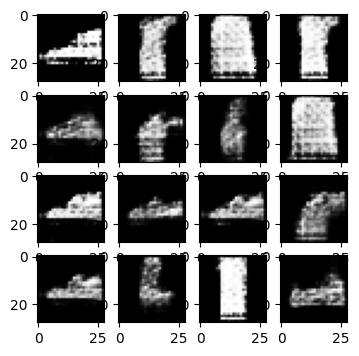

On epoch 35 result is:


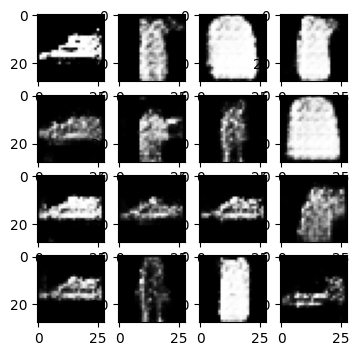

On epoch 40 result is:


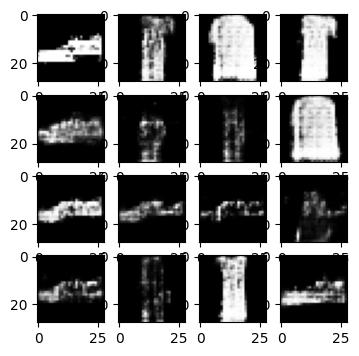

On epoch 45 result is:


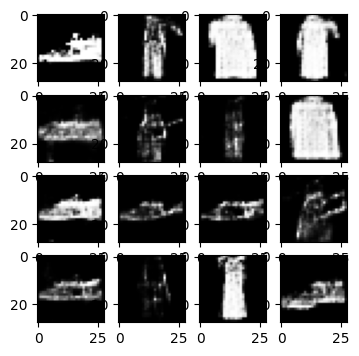

On epoch 50 result is:


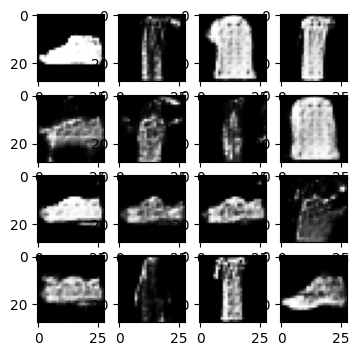

On epoch 55 result is:


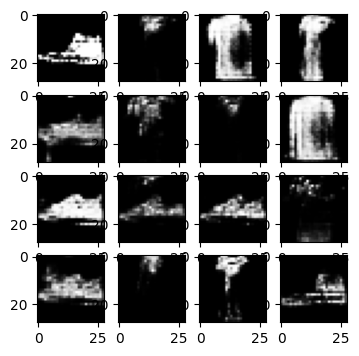

On epoch 60 result is:


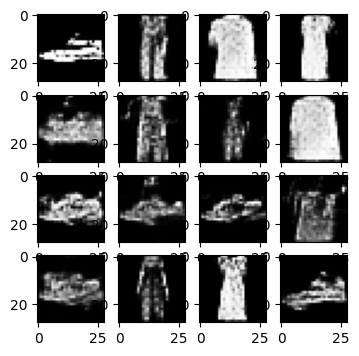

On epoch 65 result is:


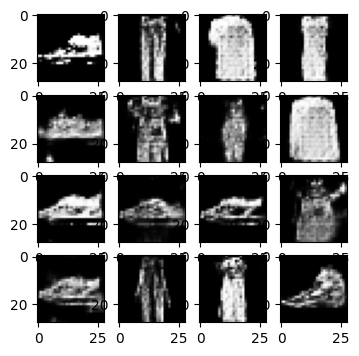

On epoch 70 result is:


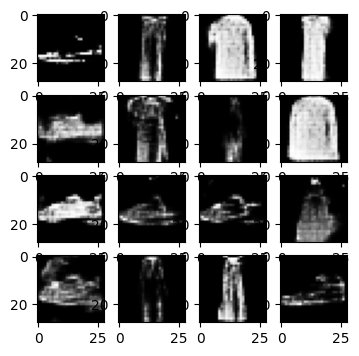

On epoch 75 result is:


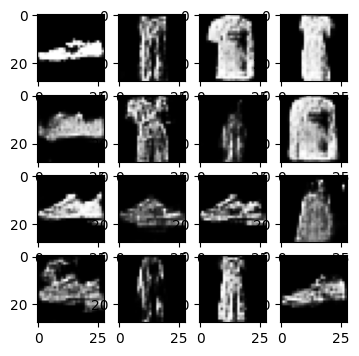

On epoch 80 result is:


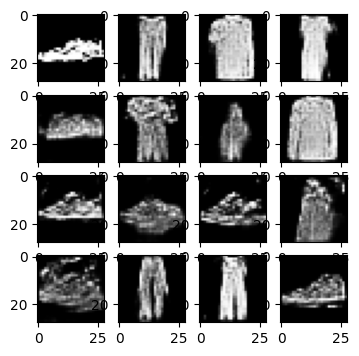

On epoch 85 result is:


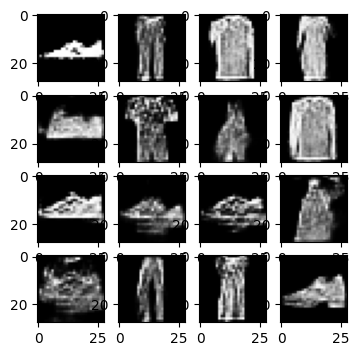

On epoch 90 result is:


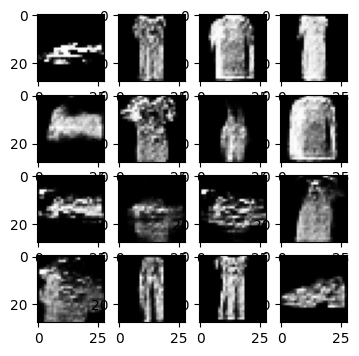

On epoch 95 result is:


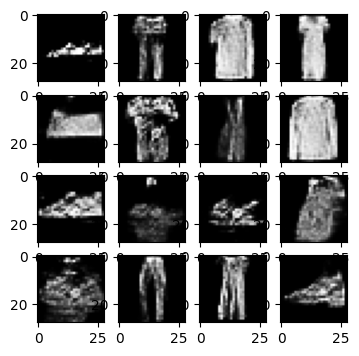

In [100]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
mod_generator = models_generator()
mod_discriminator = models_discriminator()

training_m(train_set, 100)